In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tqdm

In [2]:
def mass_spring_damper(zeta, m ,k, gamma, v1, v2, tspan, omega_d):
    # zeta: damping ratio
    # omega_n: natural frequency
    # gamma: forcing amplitude
    # v1: initial velocity
    # v2: initial displacement
    # tspan: time span
    # omega_d: forcing frequency
    # returns: time, velocity, displacement
    #%%
    omega_n = np.sqrt(k/m)
    vi = lambda t: v1*np.sin(omega_d*t) + v2*np.cos(omega_d*t)
    f_vol = lambda t: -gamma*vi(t)
    def mass_spring_damper_ode(t, y):
        # y[0] = displacement
        # y[1] = velocity
        return [y[1], -2*zeta*omega_n*y[1] - omega_n**2*y[0] + f_vol(t)/m]
    
    # Solve the ODE for the given time span
    sol = sp.integrate.solve_ivp(mass_spring_damper_ode, [tspan[0], tspan[-1]], [0, 0], t_eval=tspan)
    # 
    return sol.t, sol.y, vi(sol.t)
    
    
    

In [3]:
# define the parameters
Epoch = 350
zeta = 0.01 # damping ratio
m = 1E-1    # mass
k = 1E+5    # spring constant
B = 1E0     # coupling coefficient
C = 1E-7    # capacitance
v1 = +10    # initial voltage sin component
v2 = -10    # initial voltage cos component
u1, u2 = 2.5E-4, -5E-4 # initial displacement 
tspan = np.linspace(0, 2, 200)  # time span
lr = 3E+3  # learning rate
omega_d = 2*np.pi*5 # forcing frequency
Xt = u1 * np.sin(omega_d*tspan) + u2 * np.cos(omega_d*tspan)  # target displacement

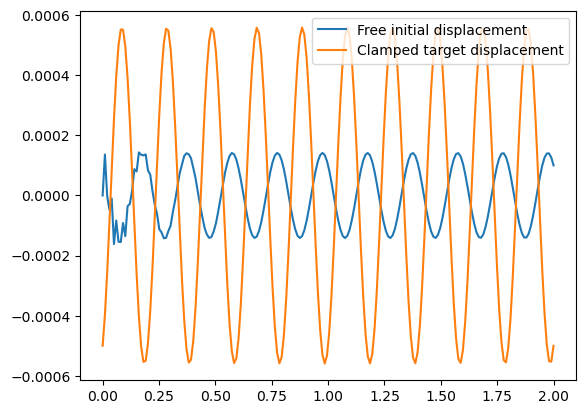

In [4]:
T, U, V = mass_spring_damper(zeta, m ,k, B, v1, v2, tspan, omega_d)
V0 = V.copy()
plt.plot(T, U[0], label='Free initial displacement')
plt.plot(T, Xt, label='Clamped target displacement')
plt.legend()
plt.show()

In [5]:

V1, V2 = [], []
for e in tqdm.tqdm(range(Epoch)):
    T, U, V = mass_spring_damper(zeta, m ,k, B, v1, v2, tspan, omega_d)
    N = int(len(T)/2)
    Q_free = B * U[0, N:] + C * V[N:]
    Q_free_sin = 2 * Q_free @ np.sin(omega_d*T[N:]) / len(T[N:])
    Q_free_cos = 2 * Q_free @ np.cos(omega_d*T[N:]) / len(T[N:])
    #
    Q_clamped = B * Xt[N:] + C * V[N:]
    Q_clamped_sin = 2 * Q_clamped @ np.sin(omega_d*T[N:]) / len(T[N:])
    Q_clamped_cos = 2 * Q_clamped @ np.cos(omega_d*T[N:]) / len(T[N:])
    #
    v1 = v1 - lr * (Q_clamped_sin - Q_free_sin)
    v2 = v2 - lr * (Q_clamped_cos - Q_free_cos)
    V1.append(v1)
    V2.append(v2)

Vf = V.copy()
    

100%|██████████| 350/350 [00:20<00:00, 17.28it/s]


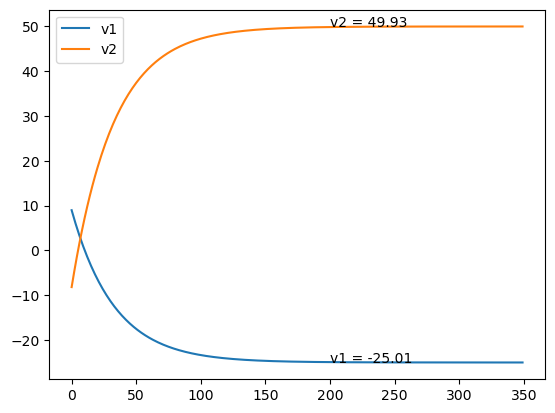

In [6]:
plt.plot(V1, label='v1')
plt.text(200, v1, 'v1 = {:.2f}'.format(v1))
plt.plot(V2, label='v2')
plt.text(200, v2, 'v2 = {:.2f}'.format(v2))
plt.legend()

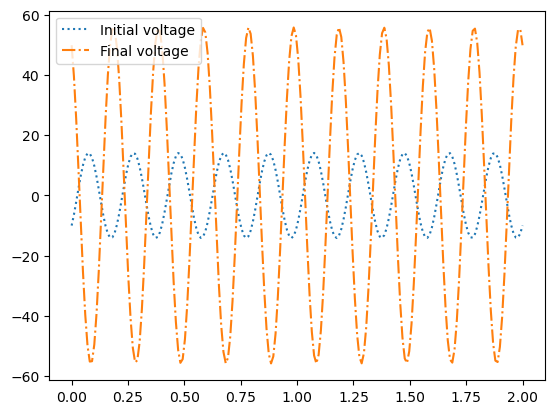

In [7]:
plt.plot(T, V0, label='Initial voltage', linestyle=':')
plt.plot(T, Vf, label='Final voltage', linestyle='-.')
plt.legend()
plt.show()

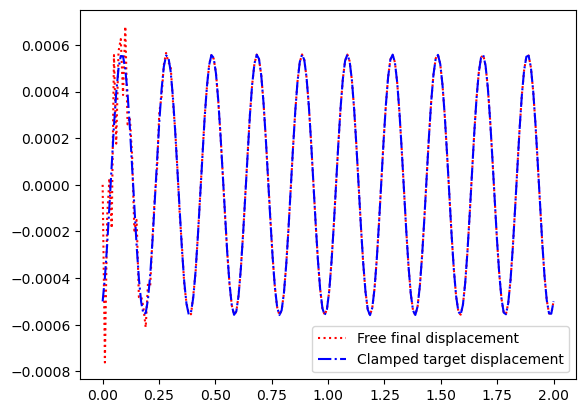

In [8]:
plt.plot(T, U[0], label='Free final displacement', linestyle=':', color='red')
plt.plot(T, Xt, label='Clamped target displacement', linestyle='-.', color='blue')
plt.legend()

In [9]:
N = int(len(T)/2)
U_sin = 2 * U[0, N:] @ np.sin(omega_d*T[N:]) / len(T[N:])
U_cos = 2 * U[0, N:] @ np.cos(omega_d*T[N:]) / len(T[N:])
print('Free displacement sin component = {:.2}%'.format((U_sin- u1)/ u1 * 100))
print('Free displacement cos component = {:.2}%'.format((U_cos- u2)/ u2 * 100))

Free displacement sin component = -0.66%
Free displacement cos component = 0.46%
